# Import libraries

In [1]:
import os
import sys
import numpy as np
import pandas as pd



repo_path = os.path.dirname(os.path.abspath(""))
CHECKOUT_PATH = repo_path
DATASET_PATH = os.path.join(repo_path, "datasets")

os.chdir(CHECKOUT_PATH)
sys.path.insert(0, CHECKOUT_PATH)

In [2]:
# import visualization packages
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.manifold import TSNE
import pandas as pd
import astartes as at
from astartes import train_test_split, train_val_test_split

from ALineMol.utils import eval_roc_auc, eval_pr_auc, eval_acc
from ALineMol.utils import plot_ID_OOD
from ALineMol.utils import split_molecules_train_test, split_molecules_train_val_test

light_color = plt.get_cmap("plasma").colors[170]
dark_color = "black"

#matplotlib.use("pgf")

matplotlib.rcParams.update(
    {
        "pgf.texsystem": "pdflatex",
        "font.family": "serif",
        "font.serif": "Computer Modern Roman",
        "font.size": 16,
        "text.usetex": True,
        "pgf.rcfonts": False,
    }
)

# Load Data and Split into Train and Test Sets 

In [4]:
DF_PATH = os.path.join(DATASET_PATH, "MoleculeNet", "HIV", "split", "scaffold", "train.csv")
df = pd.read_csv(DF_PATH)
df.shape

(37014, 2)

In [57]:
DF_PATH = os.path.join(DATASET_PATH, "MoleculeNet", "HIV", "HIV_simplified.csv")
df = pd.read_csv(DF_PATH)
df.shape

(41127, 2)

In [63]:
## Removing molecule with "DATIVE" bond type which can be problematic for the GNN models
df.drop([35278], inplace=True)

In [64]:
print(df.shape)

(41126, 2)


In [75]:
df_balanced = pd.concat([df[df['label'] == 0].sample(2000), df[df['label'] == 1]]).sample(frac=1)

In [77]:
df_balanced.to_csv(os.path.join(DATASET_PATH, "MoleculeNet", "HIV", "HIV_balanced.csv"), index=False)

In [5]:
df = pd.read_csv(os.path.join(DATASET_PATH, "MoleculeNet", "HIV", "HIV_balanced.csv"))

In [6]:
#new_df = df[['smiles', 'HIV_active']]
#new_df.columns = ['smiles', 'label']

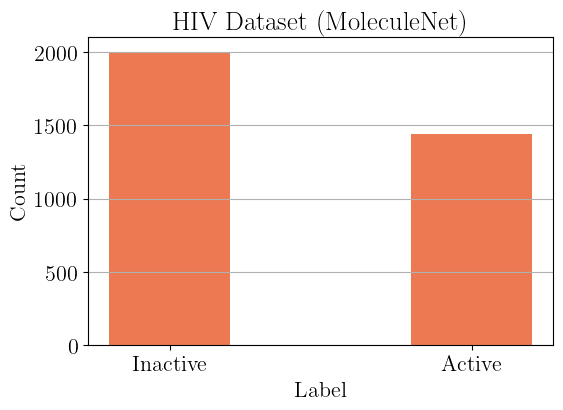

In [6]:
labels, counts = np.unique(df['label'], return_counts=True)
plt.figure(figsize=(6, 4))
plt.bar(labels, counts, align='center', width=0.4, color=light_color)
plt.xlabel("Label")
plt.ylabel("Count")
plt.title("HIV Dataset (MoleculeNet)")
plt.xticks([0, 1], ["Inactive", "Active"])
plt.grid(True, axis='y')

#plt.savefig(os.path.join(repo_path, "assets", "hiv_dataset.pdf"), bbox_inches='tight', backend='pgf')
plt.show()

In [8]:
X = np.array(df['smiles'])
y= np.array(df['label'])

In [7]:
SPLIT_PATH = os.path.join(DATASET_PATH, "MoleculeNet", "HIV", "split")

In [9]:
train, external_test = split_molecules_train_test(df, train_size=0.9, sampler="scaffold", random_state=42)

/home/scholz/miniconda3/envs/pytorch/lib/python3.10/site-packages/astartes/samplers/extrapolation/scaffold.py:44: NoMatchingScaffold: No matching scaffold was found for the 103 molecules corresponding to indices {516, 2564, 3076, 1545, 2064, 2580, 21, 2077, 2595, 43, 2092, 2094, 48, 2609, 2615, 568, 3130, 61, 1089, 3141, 2558, 588, 1614, 593, 2132, 601, 602, 603, 1115, 1116, 1629, 2145, 623, 645, 2181, 2182, 137, 3213, 654, 1170, 3221, 1178, 2715, 2720, 1699, 1705, 3243, 1202, 708, 1740, 719, 721, 214, 1244, 741, 238, 1267, 2808, 1800, 2317, 3352, 3359, 2851, 2343, 1321, 2859, 301, 2352, 818, 819, 1842, 1333, 827, 844, 858, 2396, 1892, 2405, 1385, 874, 2421, 2431, 392, 905, 1418, 1420, 919, 2968, 928, 2467, 420, 2979, 2988, 959, 1992, 465, 2006, 2010, 3051, 1522, 2550, 2043, 1022}
  warnings.warn(


In [24]:
print(train['label'].sum() / train['label'].shape[0])
print(external_test['label'].sum() / external_test['label'].shape[0])

0.4220716360116166
0.39244186046511625


In [29]:
df['label'].shape

(3443,)

In [18]:
#train, val, test = split_molecules_train_val_test(train, train_size=0.7, val_size=0.15, sampler="random", random_state=42)

In [19]:
#print(train.shape, val.shape, test.shape, external_test.shape)

(25910, 2) (5552, 2) (5553, 2) (4112, 2)


In [14]:
train.to_csv(os.path.join(SPLIT_PATH, "scaffold", "train_blanced.csv"), index=False)
external_test.to_csv(os.path.join(SPLIT_PATH, "scaffold", "external_test_balanced.csv"), index=False)

In [15]:
pd.read_csv(os.path.join(SPLIT_PATH, "scaffold", "train.csv"))

,smiles,label
0,CC(CCC1=NCCN1)C1CCC2C3CCC4CC(O)CCC4(C)C3CCC12C,0
1,CC(CCC1=NCCN1)C1CCC2C3C(O)CC4CC(O)CCC4(C)C3CCC12C,0
2,CC(CCC1=NCCN1)C1CCC2C3CCC4CC(O)CCC4(C)C3CC(O)C12C,0
3,C=C(CC1CCCS(=O)(=O)C1)S(=O)(=O)c1ccc(C)cc1,0
4,O=S(=O)(c1ccccc1)C1CC(c2nc3ccccc3[nH]2)=NO1,0
...,...,...
37010,COC(=O)C1=C(c2ccccc2)c2ccccc2C(=O)N(C2CCCCC2)C=C1,0
37011,CC1C(N2CCCCC2)N(C(=O)c2ccccc2)SC12c1ccccc1-c1c...,0
37012,CCOC(=O)NC(=O)c1cn(CCN2CCNCC2)c(=O)[nH]c1=O,0
37013,O=C(O)c1c2c(cc3c(=O)cc(-c4ccccc4)oc13)CCCC2,0


In [29]:
from sklearn.metrics import roc_auc_score, average_precision_score, roc_curve, precision_recall_curve

In [29]:
test_df = pd.read_csv(os.path.join(SPLIT_PATH, "scaffold", "external_test.csv"))
predction_df = pd.read_csv(os.path.join(repo_path, "classification_inference_results", "prediction.csv"))

In [38]:
print(roc_auc_score(test_df['label'], predction_df['label']))
print(average_precision_score(test_df['label'], predction_df['label']))

0.5250719682081508
0.04230260423982137


In [47]:
test_df[(test_df.smiles  != predction_df.canonical_smiles)]

,smiles,label
1479,O=C1c2ccccc2C(=O)N1Cc1ccccc1-c1c2ccc(n2)c(-c2c...,0
2449,Cc1ccc(C=C2C=C3OC(=O)c4cccc(c43)C2=O)cc1,0
2450,O=C1OC2=CC(=Cc3ccccc3)C(=O)c3cccc1c32,0
2451,O=C1OC2=CC(=Cc3ccc([N+](=O)[O-])cc3)C(=O)c3ccc...,0
2545,Cc1cc(S(=O)(=O)Nc2nc3cccc4cccc([nH]2)c43)c(S)c...,0
3578,CCOC(=O)c1sc2nc(SC)nc3c2c1ncn3-c1ccc(Br)cc1,0
3579,CCOC(=O)c1sc2nc(SC)nc3c2c1ncn3-c1ccccc1Cl,0


In [48]:
predction_df[(test_df.smiles  != predction_df.canonical_smiles)]

,canonical_smiles,label
1479,O=C1c2ccccc2C(=O)N1Cc1ccccc1-c1c2nc(c(-c3ccccc...,0.033909
2449,Cc1ccc(C=c2cc3oc(=O)c4cccc(c4-3)c2=O)cc1,0.186460
2450,O=c1oc2cc(=Cc3ccccc3)c(=O)c3cccc1c3-2,0.023538
2451,O=c1oc2cc(=Cc3ccc([N+](=O)[O-])cc3)c(=O)c3cccc...,0.034584
2545,Cc1cc(S(=O)(=O)NC2=Nc3cccc4cccc(c34)N2)c(S)cc1Cl,0.156992
3578,CCOC(=O)c1sc2nc(SC)nc3c2c1N=CN3c1ccc(Br)cc1,0.000818
3579,CCOC(=O)c1sc2nc(SC)nc3c2c1N=CN3c1ccccc1Cl,0.000203


In [40]:
predction_df

,canonical_smiles,label
0,O=C1C(=Cc2cccc(Oc3ccccc3)c2)S(=O)(=O)C(c2ccccc...,0.075247
1,CC1C(=O)C2C1CS2(=O)=O,0.012605
2,COc1cc(C2(O)c3ccccc3C3=NCCN32)cc(OC)c1OC,0.367022
3,Cc1cc2c(C)n(Cc3ccc(Cl)cc3Cl)nc2c(C#N)c1C,0.006438
4,Cc1cc2c(C)n(Cc3ccc(Cl)cc3Cl)nc2c(C(=O)O)c1C,0.008149
...,...,...
4107,CCN(CC)CCOc1ccc(C(C#N)=Cc2ccc(OCCN3CCCCC3)cc2)cc1,0.181808
4108,Oc1ccc(C23CC4CC(CC(C4)C2)C3)cc1,0.064840
4109,COC(=O)c1cn2ccc3ccccc3c2c1C(=O)OC,0.002126
4110,c1csc(-c2cscc2-c2cccs2)c1,0.003083


In [37]:
roc_curve(test_df['label'], predction_df['label'])


3

In [5]:
from ALineMol.utils import eval_roc_auc, eval_pr_auc, eval_acc
df1= pd.read_csv(os.path.join(SPLIT_PATH, "scaffold", "external_test.csv"))
df2 = pd.read_csv(os.path.join(repo_path, "classification_inference_results", "prediction.csv"))

print(f"ROC-AUC score: {eval_roc_auc(df1, df2)}")
print(f"PR-AUC score: {eval_pr_auc(df1, df2)}")
print(f"Accuracy score: {eval_acc(df1, df2)}")

ROC-AUC score: 0.8156075856744038
PR-AUC score: 0.3042235499086715
Accuracy score: 0.9615758754863813


In [ ]:
exteral_test_path = os.path.join(SPLIT_PATH, "scaffold", "external_test.csv")
trained_model_path = os.path.join(repo_path, "classification_results", "HIV", "gin_supervised_contextpred", "1")
inference_result_path = os.path.join(repo_path, "classification_inference_results", "HIV", "gin_supervised_contextpred")

import subprocess
result = subprocess.run(["python", "scripts/classification_inference.py", "-f", "exteral_test_path", "-sc", "smiles", "-tp", "trained_model_path", "-ip", "inference_result_path", "-s"], shell=True, stdout=subprocess.PIPE, stderr=subprocess.PIPE)
print(result)

In [19]:
trained_model_path

'/home/scholz/Documents/hfooladi/ALine/ALineMol/classification_results/HIV/gin_supervised_infomax/1'

In [6]:
model_names=["GCN","GAT", "Weave", "MPNN", "AttentiveFP", "NF", "gin_supervised_contextpred", "gin_supervised_edgepred", "gin_supervised_masking", "gin_supervised_infomax"]
ID_test_score=[]

for model_name in model_names:
    df = pd.read_csv(os.path.join("classification_results", "HIV", model_name, "1", "eval.txt"), sep=":", header=None)
    ID_test_score.append(df.iloc[1, 1])

OOD_test_score=[]
df1= pd.read_csv(os.path.join(SPLIT_PATH, "scaffold", "external_test.csv"))
for model_name in model_names:
    df = pd.read_csv(os.path.join("classification_inference_results", "HIV", model_name, "1", "prediction.csv"))
    OOD_test_score.append(eval_roc_auc(df1, df))

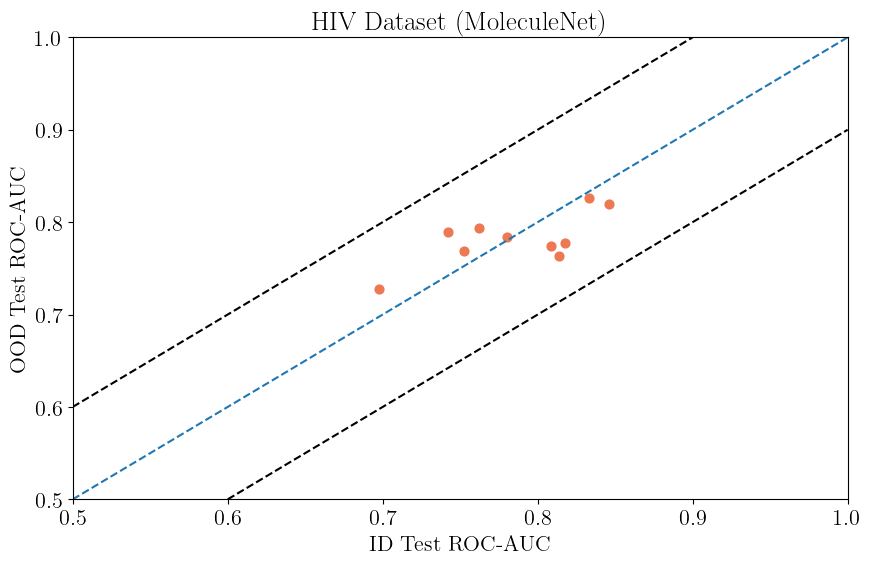

In [81]:
fig, ax = plt.subplots(1, 1, figsize=(10, 6))
ax.scatter(ID_test_score, OOD_test_score, color=light_color, s=40)
ax.axline((0.6, 0.6), slope=1, linestyle="--")
ax.axline((0.5, 0.6), (1, 1.1), color=dark_color, linestyle="--")
ax.axline((0.5, 0.4), (1, 0.9), color=dark_color, linestyle="--")

ax.set_title("HIV Dataset (MoleculeNet)")
ax.set_xlabel("ID Test ROC-AUC")
ax.set_ylabel("OOD Test ROC-AUC")


ax.set_xlim(0.5, 1)
ax.set_ylim(0.5, 1)

ax.grid(False)

fig.savefig(os.path.join(repo_path, "assets", "hiv_roc_auc_ID_OOD.pdf"), bbox_inches='tight', backend='pgf')
plt.show()

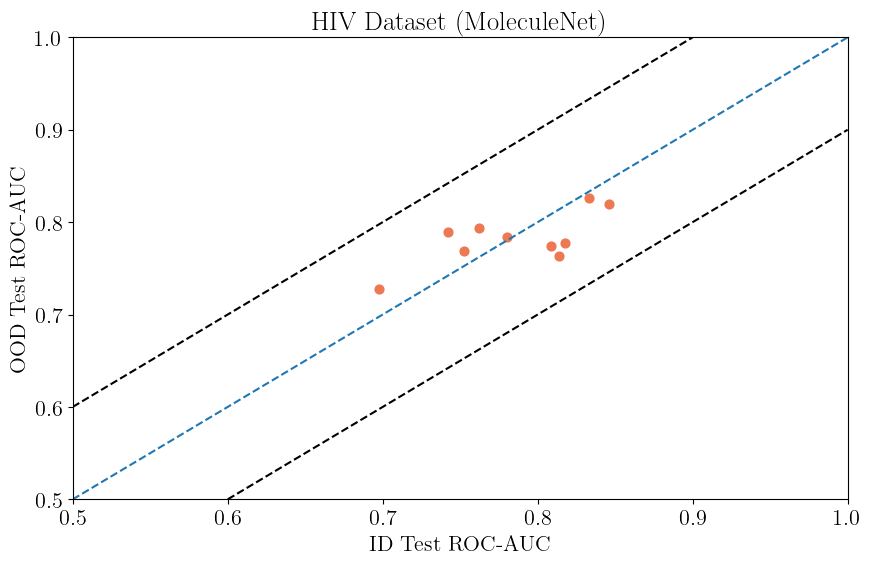

In [8]:
plot_ID_OOD(ID_test_score, OOD_test_score)

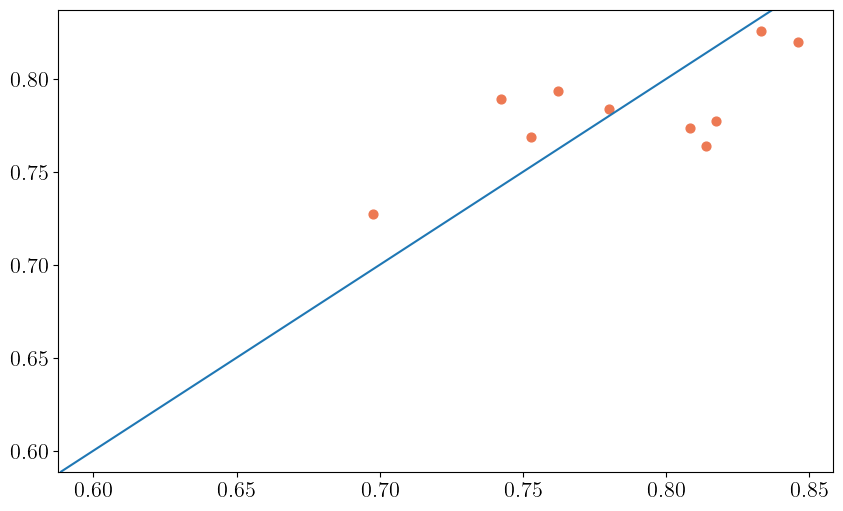

In [48]:
dffig, ax = plt.subplots(1, 1, figsize=(10, 6))
ax.scatter(ID_test_score, OOD_test_score, color=light_color, s=40)
ax.axline((0.6, 0.6), slope=1)

plt.show()

In [10]:
model_name="Weave"
!cat classification_results/HIV/$model_name/1/eval.txt | head -2 | tail -1 | cut -d : -f 2

 0.7527920148160909


In [15]:
df = pd.read_csv(os.path.join("classification_results", "HIV", "GCN" , "1", "eval.txt"), sep=":", header=None)

In [5]:
from dgllife.utils import PretrainAtomFeaturizer, PretrainBondFeaturizer

In [8]:
from rdkit import Chem
import torch
mol = Chem.MolFromSmiles(df["smiles"][0])

In [40]:
edge_features = []
num_bonds = mol.GetNumBonds()

In [46]:
for j, smile in enumerate(df["smiles"]):
    mol = Chem.MolFromSmiles(smile)
    num_bonds = mol.GetNumBonds()
    for i in range(num_bonds):
        bond = mol.GetBondWithIdx(i)
        bond_feature = bond.GetBondType().__str__()
        if bond_feature == "DATIVE":
            print(j)
        edge_features.append(bond_feature)

In [47]:
df.to_csv(os.path.join(repo_path, "datasets", "MoleculeNet", "HIV", "split", "scaffold", "train.csv"), index=False)

In [35]:
from collections import Counter
Counter(edge_features)

Counter({'SINGLE': 554463,
         'AROMATIC': 471587,
         'DOUBLE': 99070,
         'TRIPLE': 4566,
         'DATIVE': 2})

In [6]:
edge_features = []
num_bonds = mol.GetNumBonds()
if num_bonds == 0:
    assert self._self_loop, \
        'The molecule has 0 bonds and we should set self._self_loop to True.'

# Compute features for each bond
for i in range(num_bonds):
    bond = mol.GetBondWithIdx(i)
    bond_feats = [
        self._bond_types.index(bond.GetBondType()),
        self._bond_direction_types.index(bond.GetBondDir())
    ]
    edge_features.extend([bond_feats, bond_feats.copy()])

if self._self_loop:
    self_loop_features = torch.zeros((mol.GetNumAtoms(), 2), dtype=torch.int64)
    self_loop_features[:, 0] = len(self._bond_types)

if num_bonds == 0:
    edge_features = self_loop_features
else:
    edge_features = np.stack(edge_features)
    edge_features = F.zerocopy_from_numpy(edge_features.astype(np.int64))
    if self._self_loop:
        edge_features = torch.cat([edge_features, self_loop_features], dim=0)

,smiles,label
0,CCC1=[O+][Cu-3]2([O+]=C(CC)C1)[O+]=C(CC)CC(CC)...,0
1,C(=Cc1ccccc1)C1=[O+][Cu-3]2([O+]=C(C=Cc3ccccc3...,0
2,CC(=O)N1c2ccccc2Sc2c1ccc1ccccc21,0
3,Nc1ccc(C=Cc2ccc(N)cc2S(=O)(=O)O)c(S(=O)(=O)O)c1,0
4,O=S(=O)(O)CCS(=O)(=O)O,0
...,...,...
41122,CCC1CCC2c3c([nH]c4ccc(C)cc34)C3C(=O)N(N(C)C)C(...,0
41123,Cc1ccc2[nH]c3c(c2c1)C1CCC(C(C)(C)C)CC1C1C(=O)N...,0
41124,Cc1ccc(N2C(=O)C3c4[nH]c5ccccc5c4C4CCC(C(C)(C)C...,0
41125,Cc1cccc(N2C(=O)C3c4[nH]c5ccccc5c4C4CCC(C(C)(C)...,0
